<a href="https://colab.research.google.com/github/jleandroforte/Desafio-Evaluacion-ML_Forte/blob/main/Desaf%C3%ADo_Evaluaci%C3%B3nML_Forte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Objetivos de la entrega**

En el desafío anterior evaluamos un modelo de regresión logística para predecir si una observación redunda en una venta o no.

Recordemos que una de nuestras variables, "order", toma el valor 1 cuando se trata de una venta y 0 caso contrario.

Vimos que un modelo simple y con una relativamente leve carga de Feature Engineering arrojaba un accuracy del 90%, lo cual habla de una estructura de datos adecuada para predecir ventas.  

En esta entrega vamos a profundizar y mejorar la aplicación de dicho modelo de regresión logística a través de los siguientes pasos:

> a) Feature Engineering: Aplicaremos Forward Selection, usando el accuracy como medida a optimizar, para quedarnos sólo con las variables explicativas relevantes a la hora de predecir ventas.

> b) Hypertuning de parámetros: Vamos a aplicar lo que aprendimos en las clases que transcurrieron desde la última entrega en materia de Grid Search, con el objetivo de tener los mejores parámetros para nuestra regresión logística.

>c) Una vez hecho esto, vamos a comparar los resultados del modelo con los de la entrega anterior, y vamos a agregar más formas de evaluar la eficacia del modelo, en función de lo que aprendimos en la clase 45, a la matriz de confusión, z-scores y el accuracy vamos a agregar precisión, sensibilidad, F1 Score y Curva ROC.



#**Breve Introducción a la base de datos**

El dataset con el que vamos a trabajar recopila datos de ventas y actividad de los clientes en el sitio web de una farmacia online a lo largo de 90 días.

Tenemos información sobre varias características de los productos que serán detalladas en secciones siguientes, sus precios, los precios de la competencia y comportamiento de los clientes, si hacen click en un producto, si los colocan en una canasta de productos y finalmente si compran un producto. Nótese que no todas las líneas representan ventas.

La clave del dataset es que la farmacia sigue una política de 'pricing dinámico' donde los precios de cada producto son ajustados diariamente, dentro de ciertas bandas.

#**Objetivos y estrategia de estimación**

En este trabajo vamos a enfocarnos en predecir si, dadas las características cada observación o fila del dataset, se va a producir una venta o no.

Recordemos que tenemos una variable llamada Order que toma valores 0 y 1, cuando order==1, la observación representa una venta, y cuando toma el valor 0 no se trata de una venta.

Siendo que nuestra variable dependiente es categórica y toma valores 0 (no-venta) y 1 (venta) vamos a proponer un modelo de regresión logística.

En otros trabajos el foco ha estado en predecir el revenue, y se ha demostrado en la segunda pre-entrega que el modelo de regresión lineal simple no es apropiado para nuestra estructura de datos, sólo como muestra, el r2 era de
~0.5.

Estimar la probabilidad de ventas, aparte de ser una pregunta de investigación importantísima en sí misma, puede funcionar como paso intermedio para estimar el revenue. Para ver por qué, recordemos que el revenue surge de las cantidades vendidas multiplicadas por el precio. El dataset contiene los precios, y la cantidad vendida en el set de testing se puede obtener construyendo una variable dividiendo revenue por precio, de modo que, si logramos predecir correctamente las ventas, podremos calcular el revenue.


In [ ]:
# Importamos las liberías necesarias.
from google.colab import drive
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression


drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Entregas/DB'

Mounted at /content/drive
/content/drive/MyDrive/Entregas/DB


In [ ]:
# importamos los archivos y los combinamos en un solo dataset llamado 'farmacia' a través de la variable product id.

pricing_class=pd.read_csv("class.csv", sep='|')
pricing_items=pd.read_csv('items.csv', sep='|')
pricing_train=pd.read_csv('train.csv', sep='|')

dataset = pd.merge(pricing_train, pricing_items, on='pid');
farmacia=pd.DataFrame(dataset)

In [ ]:
farmacia

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
1,20746,2,6570,0,2,14.60,0,1,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
2,35477,2,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
3,61647,4,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
4,87130,5,6570,0,2,14.60,0,1,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,2712203,91,20700,0,2,NaN,0,0,1,5.91,...,753,10OK0F,250,G,TEE,0,52,NaN,NaN,6.22
2755999,2713825,91,12000,0,2,NaN,1,0,0,13.01,...,811,20OHG,1,ST,BAN,0,53,NaN,NaN,13.70
2756000,2714766,91,10485,0,2,2.43,1,0,0,2.87,...,61,21OS1,60,G,TEE,0,52,1.0,NaN,3.03
2756001,2718999,91,15158,0,2,3.69,1,0,0,4.77,...,811,20OI2,1,ST,BAN,0,53,NaN,NaN,4.14


In [ ]:
farmacia.shape

(2756003, 21)

In [ ]:
farmacia.info

<bound method DataFrame.info of           lineID  day    pid  adFlag  availability  competitorPrice  click  \
0              1    1   6570       0             2            14.60      1   
1          20746    2   6570       0             2            14.60      0   
2          35477    2   6570       0             2            14.60      1   
3          61647    4   6570       0             2            14.60      1   
4          87130    5   6570       0             2            14.60      0   
...          ...  ...    ...     ...           ...              ...    ...   
2755998  2712203   91  20700       0             2              NaN      0   
2755999  2713825   91  12000       0             2              NaN      1   
2756000  2714766   91  10485       0             2             2.43      1   
2756001  2718999   91  15158       0             2             3.69      1   
2756002  2733652   92  12233       0             2            14.06      1   

         basket  order  price  ...  manufacturer   group content unit  \
0             0      0  16.89  ...           255    2FOI      50   ML   
1             1      0  16.89  ...           255    2FOI      50   ML   
2             0      0  16.89  ...           255    2FOI      50   ML   
3             0      0  16.89  ...           255    2FOI      50   ML   
4             1      0  16.89  ...           255    2FOI      50   ML   
...         ...    ...    ...  ...           ...     ...     ...  ...   
2755998       0      1   5.91  ...           753  10OK0F     250    G   
2755999       0      0  13.01  ...           811   20OHG       1   ST   
2756000       0      0   2.87  ...            61   21OS1      60    G   
2756001       0      0   4.77  ...           811   20OI2       1   ST   
2756002       0      0  16.69  ...            71    2FOI      50   ML   

        pharmForm genericProduct  salesIndex  category  campaignIndex    rrp  
0             TRO              0          40     193.0            NaN  18.25  
1             TRO              0          40     193.0            NaN  18.25  
2             TRO              0          40     193.0            NaN  18.25  
3             TRO              0          40     193.0            NaN  18.25  
4             TRO              0          40     193.0            NaN  18.25  
...           ...            ...         ...       ...            ...    ...  
2755998       TEE              0          52       NaN            NaN   6.22  
2755999       BAN              0          53       NaN            NaN  13.70  
2756000       TEE              0          52       1.0            NaN   3.03  
2756001       BAN              0          53       NaN            NaN   4.14  
2756002       TRO              0          40       NaN            NaN  17.04  

[2756003 rows x 21 columns]>

In [ ]:
farmacia.describe(include='all')

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
count,2.756003e+06,2.756003e+06,2.756003e+06,2.756003e+06,2.756003e+06,2.655316e+06,2.756003e+06,2.756003e+06,2.756003e+06,2.756003e+06,...,2.756003e+06,2756003,2756003,2756003,2561879,2.756003e+06,2.756003e+06,2.668609e+06,468035,2.756003e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,533,548,8,278,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22OI3,50,ST,TAB,NaN,NaN,NaN,B,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,159787,380869,1332256,252906,NaN,NaN,NaN,251965,NaN
mean,1.378002e+06,4.992118e+01,1.044790e+04,3.177888e-01,1.111035e+00,1.277288e+01,5.743198e-01,1.698423e-01,2.558379e-01,1.385008e+01,...,1.744467e+02,NaN,NaN,NaN,NaN,1.055086e-01,4.624467e+01,1.154272e+02,NaN,1.830907e+01
std,7.955897e+05,2.529451e+01,6.456013e+03,4.656170e-01,3.921785e-01,1.275295e+01,4.944458e-01,3.754943e-01,4.363312e-01,1.362307e+01,...,1.873093e+02,NaN,NaN,NaN,NaN,3.072077e-01,6.422195e+00,9.368947e+01,NaN,1.866168e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-02,...,1.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00,4.000000e+01,1.000000e+00,NaN,7.000000e-02
25%,6.890015e+05,3.100000e+01,4.313000e+03,0.000000e+00,1.000000e+00,5.480000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,...,5.600000e+01,NaN,NaN,NaN,NaN,0.000000e+00,4.000000e+01,4.600000e+01,NaN,7.980000e+00
50%,1.378002e+06,5.000000e+01,1.007700e+04,0.000000e+00,1.000000e+00,8.990000e+00,1.000000e+00,0.000000e+00,0.000000e+00,9.850000e+00,...,1.040000e+02,NaN,NaN,NaN,NaN,0.000000e+00,4.000000e+01,9.200000e+01,NaN,1.317000e+01
75%,2.067002e+06,7.100000e+01,1.614400e+04,1.000000e+00,1.000000e+00,1.506000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.645000e+01,...,2.200000e+02,NaN,NaN,NaN,NaN,0.000000e+00,5.300000e+01,1.520000e+02,NaN,2.195000e+01


In [ ]:
farmacia.dtypes

lineID               int64
day                  int64
pid                  int64
adFlag               int64
availability         int64
competitorPrice    float64
click                int64
basket               int64
order                int64
price              float64
revenue            float64
manufacturer         int64
group               object
content             object
unit                object
pharmForm           object
genericProduct       int64
salesIndex           int64
category           float64
campaignIndex       object
rrp                float64
dtype: object

#**Descripción de las variables:**

**Vamos a proceder a describir verbalmente nuestras variables, cuando se trate de variables que no varían en el tiempo, se explicita en la descripción**

**day**: el día que se registra, recordemos que tenemos datos 91 días de ventas y otras acciones de usuarios en el sitio web. El datatype es int.

**pid**: El id del producto, como vimos, tenemos más de 22 mil productos. El datatype es int, los productos se identifican por un numero, no por su nombre. Es una variable invariante.

**adFlag**: Nos indica si el producto en cuestión es objeto de una campaña publicitaria. El valor 1 indica que hubo capaña, y 0 indica que no la hubo.

**availability**: Status de disponibilidad de los productos, toma los valores {1,2,3,4}

**competitorPrice** : El precio de la competencia para un producto. Es un floating point.

**click, basket, order**: Denotan acciones de los usuarios, si hicieron click en un producto, si lo colocaron en un carrito de compra (pero no necesariamente lo compraron), mientras que order indica si efectivamente el registro denota una compra. Las 4 variables toman los valores {0,1}, donde 1 denota acción (compra, carrito de compra, click) y el 0 la ausencia de acción.

**price**: El precio efectivamente asociado a la observacion. Recordemos que la farmacia sigue una estrategia de 'pricing dinámico', los precios de cada producto se ajustan día a día. También es importante tener en cuenta que no se trata de precios customizados para clientes, los ajustes de precios son diarios y automáticos. Esto introduce una gran variabilidad en las observaciones que nos permitirá evaluar la influencia de los precios en las ventas, y es el insumo fundamental para predecir la demanda futura en función de como ajustemos nuestros precios. El precio es un floating point.

**revenue**: Los ingresos por ventas. Es decir, el precio multiplicado por las cantidades compradas (que no observamos, solo observamos precios, compras (la variable 'order') y revenue). El revenue es un floating point.

**manufacturer**: El fabricante de cada producto. Se identifica mediante un numero entero. Es invariante, al igual que el product id.

**group**: El grupo de productos, combina letras y numeros. Es invariante.

**content**: El contenido de un producto, se identifica bajo la nomenclatura numeroXnumero, por caso: 5X10. Es invariante.

**unit**: La unidad del producto, es un string de mayúsculas.Es invariante.

**pharmForm**: La dosis: son 3 letras mayúsculas. Es invariante.

**genericProduct**: Si se trata de un medicamento generico, toma los valores {0,1}, el 1 indica que se trata de un medicamento genérico. Es invariante.

**salesIndex**: un código de dispensión de medicamentos de Estados unidos. Es un entero. Es invariante.

**category**: categoría de negocio: es un numero de negocio. Es invariante.

**campaignIndex**: Tipo de campaña publicitaria de que fue objeto el producto, toma los valores {A,B,C}

**rrp**: El precio de referencia, recordemos que la farmacia ajusta los precios de cada producto diariamente, pero cada item tiene un precio de referencia, más adelante vamos a graficar algunos ejemplos. Es invariante, la variabilidad está en los precios efectivos.

#**Módulo de Limpieza de datos**

##**Tratamiento de Missing Values**

En primer lugar, vemos cuantos datos nos faltan por columna, y proponemos las siguientes soluciones para aquellas variables donde identificamos missing values:

Para competitor price vamos a reemplazar los missing values por la mediana del precio por cada producto, no en general, en caso de no disponer de un precio para algún producto, se reemplaza por la mediana de la variable en el dataset completo.

para pharmForm, al menos por ahora, vamos a reemplazar por el valor más frecuente, a nivel de producto y no en el agregado. No se pueden usar medidas como media o mediana porque no es una variable numérica.

Para category usamos el mismo procedimiento que para pharmForm, con las mismas consideraciones.

Para campaing index, que en el dataset toma los valores {A,B,C}, e indica el tipo de campaña publicitaria que se llevó a cabo, tenemos 2 tipos de tratamiento, dado que es dependiente de adFlag, solo cuando adFlag es igual a 1 hay campaña publicitaria, de modo que si adFlag==0, reemplazamos por "D", que es una manera de indicar que no hay campaña publicitaria, mientras que para los casos en que adFlag==1 reemplazamos por la moda o valor más repetido a nivel de producto.

In [ ]:
datos_faltantes = farmacia.isnull().sum()
print("Datos faltantes por columna: " , datos_faltantes)

Datos faltantes por columna:  lineID                   0
day                      0
pid                      0
adFlag                   0
availability             0
competitorPrice     100687
click                    0
basket                   0
order                    0
price                    0
revenue                  0
manufacturer             0
group                    0
content                  0
unit                     0
pharmForm           194124
genericProduct           0
salesIndex               0
category             87394
campaignIndex      2287968
rrp                      0
dtype: int64


Reemplazo de missing values para la variable competitorPrice, si a nivel de producto no hay una mediana, se reemplaza por la mediana de la columna en general.

In [ ]:
medianas_faltantes = farmacia.groupby('pid')['competitorPrice'].transform('median') # recordemos que pid es 'Product Id', por eso hacemos el reemplazo a ese nivel.

farmacia['competitorPrice'] = farmacia['competitorPrice'].fillna(medianas_faltantes)

# En los casos no capturados por las lineas anteriores reemplazamos por la mediana general de la variable:
mediana_competitorPrice = farmacia['competitorPrice'].median()

farmacia['competitorPrice'] = farmacia['competitorPrice'].fillna(mediana_competitorPrice)

Reemplazo de missing values para las variables pharmForm y category, estamos usando el valor más frecuente, por eso la función hace referencia a la moda ("mode")

In [ ]:
def completar_pharmform(series):
    if series.mode().empty:
        return series
    else:
        moda_pharmForm = series.mode().iloc[0]
        return series.fillna(moda_pharmForm)

farmacia['pharmForm'] = farmacia.groupby('pid')['pharmForm'].transform(completar_pharmform)

farmacia['pharmForm'].fillna('default_value', inplace=True) # esta ultima linea de codigo es para reemplazar missing values en casos no capturados por la funcion anterior.

In [ ]:
def completar_category(series):
    if series.mode().empty:
        return series
    else:
        moda_category = series.mode().iloc[0]
        return series.fillna(moda_category)

farmacia['category'] = farmacia.groupby('pid')['category'].transform(completar_category)

farmacia['category'].fillna('default_value', inplace=True) # esta ultima linea de codigo es para reemplazar missing values en casos no capturados por la funcion anterior.



Reemplazo de missing values para campaignIndex, recordemos el metodo:
tenemos 2 tipos de tratamiento, dado que es dependiente de adFlag, solo cuando adFlag es igual a 1 hay campaña publicitaria, de modo que si adFlag==0, reemplazamos por "D" (ya que las campañas son {A,B,C}, y de esta forma con la "D" podemos identificar rápidamente que no hay campaña) para los casos en que adFlag==1 reemplazamos por la moda o valor más repetido a nivel de producto.  

In [ ]:
farmacia['campaignIndex'].fillna('D', inplace=True)

mask = (farmacia['adFlag'] == 1) & (farmacia['campaignIndex'].isna())
farmacia.loc[mask, 'campaignIndex'] = farmacia[mask].groupby('pid')['campaignIndex'].transform(lambda x: x.mode().iloc[0])

farmacia['campaignIndex'].fillna('default_value', inplace=True) # esta ultima linea de codigo es para reemplazar missing values en casos no capturados por la funcion anterior.


Ahora constatamos que ya no tenemos más missing values:



In [ ]:
datos_faltantes = farmacia.isnull().sum()
print("Datos faltantes por columna: " , datos_faltantes)


Datos faltantes por columna:  lineID             0
day                0
pid                0
adFlag             0
availability       0
competitorPrice    0
click              0
basket             0
order              0
price              0
revenue            0
manufacturer       0
group              0
content            0
unit               0
pharmForm          0
genericProduct     0
salesIndex         0
category           0
campaignIndex      0
rrp                0
dtype: int64


##**Encoding de Variables Categoricas**

Repasemos nuestras variable categóricas y sus valores unicos para saber si son factibles de aplicar encoding.

In [ ]:
farmacia.describe(include='object')

,group,content,unit,pharmForm,category,campaignIndex
count,2756003,2756003,2756003,2756003,2756003.0,2756003
unique,533,548,8,279,410.0,4
top,22OI3,50,ST,TAB,50.0,D
freq,159787,380869,1332256,252906,118323.0,2287968


Como vemos, tenemos 6 variables que quedemos congertir a dummies para poder usar como variables explicativas de un modelo. Como se puede observar, algunas de las variables tienen varios cientos de valores únicos, lo cual consume la totalidad de la memoria de esta versión de Colab. Vamos a limitar el encoding a las variables unit y campaignIndex.

En el caso de la variable group, recordemos que se trata de agrupamientos de productos, para los cuales tenemos la variable pid (product ID), de modo que no estariamos perdiendo informacion al excluirla de un modelo, si incluimos el product id.


Para ello usamos el metodo get_dummies

In [ ]:
dummies = pd.DataFrame(pd.get_dummies(farmacia[['unit', 'campaignIndex']]))

In [ ]:
dummies.dtypes

unit_CM            uint8
unit_G             uint8
unit_KG            uint8
unit_L             uint8
unit_M             uint8
unit_ML            uint8
unit_P             uint8
unit_ST            uint8
campaignIndex_A    uint8
campaignIndex_B    uint8
campaignIndex_C    uint8
campaignIndex_D    uint8
dtype: object

In [ ]:
dummies

,unit_CM,unit_G,unit_KG,unit_L,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D
0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,0,1,0,0,0,0,0,0,0,0,0,1
2755999,0,0,0,0,0,0,0,1,0,0,0,1
2756000,0,1,0,0,0,0,0,0,0,0,0,1
2756001,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
farmacia_final = pd.concat([farmacia, dummies], axis=1) #creamos un dataset que sea nuestras variables originales y las dummies.

In [ ]:
farmacia_final

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,unit_KG,unit_L,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,0,0,0,1,0,0,0,0,0,1
1,20746,2,6570,0,2,14.60,0,1,0,16.89,...,0,0,0,1,0,0,0,0,0,1
2,35477,2,6570,0,2,14.60,1,0,0,16.89,...,0,0,0,1,0,0,0,0,0,1
3,61647,4,6570,0,2,14.60,1,0,0,16.89,...,0,0,0,1,0,0,0,0,0,1
4,87130,5,6570,0,2,14.60,0,1,0,16.89,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,2712203,91,20700,0,2,8.99,0,0,1,5.91,...,0,0,0,0,0,0,0,0,0,1
2755999,2713825,91,12000,0,2,8.99,1,0,0,13.01,...,0,0,0,0,0,1,0,0,0,1
2756000,2714766,91,10485,0,2,2.43,1,0,0,2.87,...,0,0,0,0,0,0,0,0,0,1
2756001,2718999,91,15158,0,2,3.69,1,0,0,4.77,...,0,0,0,0,0,1,0,0,0,1


In [ ]:
farmacia_final.dtypes

lineID               int64
day                  int64
pid                  int64
adFlag               int64
availability         int64
competitorPrice    float64
click                int64
basket               int64
order                int64
price              float64
revenue            float64
manufacturer         int64
group               object
content             object
unit                object
pharmForm           object
genericProduct       int64
salesIndex           int64
category            object
campaignIndex       object
rrp                float64
unit_CM              uint8
unit_G               uint8
unit_KG              uint8
unit_L               uint8
unit_M               uint8
unit_ML              uint8
unit_P               uint8
unit_ST              uint8
campaignIndex_A      uint8
campaignIndex_B      uint8
campaignIndex_C      uint8
campaignIndex_D      uint8
dtype: object

In [ ]:
farmacia_final.shape # Nos queda un dataset donde no tenemos pérdida de filas, e incrementamos nuestros features a 33.

(2756003, 33)

#**Cambio de escala de variables numéricas continuas**

En esta sección vamos a usar el módulo scaler de scikit-learn para modificar la escala de un conjunto de variables numéricas continuas, no categóricas.

En concreto, vamos a re-escalar los precios (price), precios de referencia (rrp), precios de la competencia y revenue.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
variables_re_escaladas = ["revenue", "price", "rrp" , "competitorPrice"] # las 4 variables que vamos a re-escalar.

scaler = StandardScaler() #creamos un objeto que sea el Scaler de sklearn.

columnas_re_escaladas = scaler.fit_transform(farmacia_final[variables_re_escaladas]) #Aplicamos ("fiteamos") el scaler a nuestro set de variables de interés

dataset_re_escalado = pd.DataFrame(columnas_re_escaladas, columns=variables_re_escaladas) # Se genera un dataset con nuevas escalas para nuestras variables de interés

variables_no_re_escaladas = farmacia_final.drop(columns=variables_re_escaladas) # las restantes columnas del dataset

farmacia_re_escalada = pd.concat([dataset_re_escalado, variables_no_re_escaladas], axis=1) # Concatenamos las variables con cambio de escala con el resto.


In [ ]:
farmacia_re_escalada

,revenue,price,rrp,competitorPrice,lineID,day,pid,adFlag,availability,click,...,unit_KG,unit_L,unit_M,unit_ML,unit_P,unit_ST,campaignIndex_A,campaignIndex_B,campaignIndex_C,campaignIndex_D
0,-0.366336,0.223145,-0.003165,0.155889,1,1,6570,0,2,1,...,0,0,0,1,0,0,0,0,0,1
1,-0.366336,0.223145,-0.003165,0.155889,20746,2,6570,0,2,0,...,0,0,0,1,0,0,0,0,0,1
2,-0.366336,0.223145,-0.003165,0.155889,35477,2,6570,0,2,1,...,0,0,0,1,0,0,0,0,0,1
3,-0.366336,0.223145,-0.003165,0.155889,61647,4,6570,0,2,1,...,0,0,0,1,0,0,0,0,0,1
4,-0.366336,0.223145,-0.003165,0.155889,87130,5,6570,0,2,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,1.942442,-0.582841,-0.647802,-0.291124,2712203,91,20700,0,2,0,...,0,0,0,0,0,0,0,0,0,1
2755999,-0.366336,-0.061666,-0.246980,-0.291124,2713825,91,12000,0,2,1,...,0,0,0,0,0,1,0,0,0,1
2756000,-0.366336,-0.805992,-0.818740,-0.813834,2714766,91,10485,0,2,1,...,0,0,0,0,0,0,0,0,0,1
2756001,-0.366336,-0.666523,-0.759260,-0.713435,2718999,91,15158,0,2,1,...,0,0,0,0,0,1,0,0,0,1


#**Regresión Logistica**

##**Preparación del modelo**

Seleccionamos nuestra variable dependiente **order** y excluimos las variables categoricas que encodeamos para no generar duplicaciones.

Tambien voy a excluir el revenue como regresor, recodemos que estamos tratando de predecir si una línea va a derivar en una venta en funcion de sus caracteristicas, y el revenue por definición es precio por cantidad vendida cuando hay ventas, entonces, el revenue tiene lugar después que un cliente decide una compra, no puede ser nunca una variable explicativa de las ventas.

Tambien eliminamos lineID como variable independiente, no tiene valor explicativo

In [ ]:
X = farmacia_re_escalada.drop([ 'lineID', 'order' , 'group', 'content', 'unit', 'category','campaignIndex', 'pharmForm' , 'revenue' ], axis=1)

y = farmacia_re_escalada['order']

In [ ]:
print(X.dtypes) #volvemos a chequear que nuestras variables explicativas no son strings

price              float64
rrp                float64
competitorPrice    float64
day                  int64
pid                  int64
adFlag               int64
availability         int64
click                int64
basket               int64
manufacturer         int64
genericProduct       int64
salesIndex           int64
unit_CM              uint8
unit_G               uint8
unit_KG              uint8
unit_L               uint8
unit_M               uint8
unit_ML              uint8
unit_P               uint8
unit_ST              uint8
campaignIndex_A      uint8
campaignIndex_B      uint8
campaignIndex_C      uint8
campaignIndex_D      uint8
dtype: object


In [ ]:
#Dividimos el dataset en train y test subsets, dejamos el 20% para testing.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

##**Forward Selection**

Implementamos Forward Selection para entender que variables incluir en nuestro modelo

In [ ]:
!pip install mlxtend --upgrade # instalamos mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
reg_logistica = LogisticRegression(max_iter=1000, solver='liblinear')

#Instanciamos SFS, pasamos como parametro nuestro modelo de regresión logística, el criterio a optimizar es Accuracy.
#Como contraste, en las 2 pre-entregas previas donde modelamos una regresión lineal, usamos el r2 como criterio scoring.

sfs = SFS(reg_logistica,
          k_features=11,
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=0)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(cv=0,
                          estimator=LogisticRegression(max_iter=1000,
                                                       solver='liblinear'),
                          k_features=(11, 11), scoring='accuracy')

In [ ]:
sfs.k_feature_names_     #Lista final de features después de aplicar SFS

('price',
 'rrp',
 'competitorPrice',
 'day',
 'pid',
 'adFlag',
 'availability',
 'click',
 'basket',
 'manufacturer',
 'genericProduct')

Como puede verse, despues de hacer feature selection nos quedamos con un set de variables explicativas mucho más reducido, vamos a modificar de tal modo nuestro vector X de variables independientes para dar cuenta de este resultado y testear si podemos mejorar nuestras predicciones.

In [ ]:
# En nuestro vector x nos quedamos sólo con las variables indicadas como relevantes por el SFS
X = farmacia_re_escalada.drop([ 'lineID', 'order' , 'group', 'content', 'unit', 'category','campaignIndex', 'pharmForm' , 'revenue', 'salesIndex', 'unit_CM',

'unit_G', 'unit_KG','unit_L', 'unit_ML', 'unit_P', 'unit_ST', 'campaignIndex_A', 'campaignIndex_B', 'campaignIndex_C',  'campaignIndex_D' , 'unit_M' ], axis=1)

y = farmacia_re_escalada['order']

In [ ]:
#Constatamos que nuestro vector X de regresores contiene solo las variables sugeridas por el forward selector y validamos que no tenemos object variables
X.dtypes

price              float64
rrp                float64
competitorPrice    float64
day                  int64
pid                  int64
adFlag               int64
availability         int64
click                int64
basket               int64
manufacturer         int64
genericProduct       int64
dtype: object

##**Gridsearch**

Implementacion del GridSearch para encontrar los mejores parámetros de regresión logística

Vamos a testear cuales son las mejores penalidades a aplicar (l1, l2), el coeficiente C de regularización para evitar el overfitting.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [ ]:
reg_logistica = LogisticRegression(max_iter=1000, solver='liblinear')

grid_search = GridSearchCV(estimator=reg_logistica, param_grid=param_grid, cv=2) #Instanciamos el gridSearch usando nuestro objeto estimador "reg_logistica"
grid_search.fit(X, y)

GridSearchCV(cv=2,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [ ]:
grid_search.best_estimator_

Como vemos, el GridSearch nos lleva a ajustar nuestros parametros como C=0.001, penalty = 'l1', esto es un resultado relevante porque, como indica el manual de scikit learn, el parámetro por default es l2,  y solver liblinear.

Además, un C bajo (como es el caso con C=0.001) es indicativo de un modelo más simple orientado a evitar el overfitting.

##**Separamos el dataset en training y test Sets**

In [ ]:
#Volvemos a dividir el dataset en train y test subsets, dejamos el 20% para testing.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

##**Estimamos (fit) el modelo de regresión logística**

In [ ]:
reg_logistica = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=0.001)

reg_logistica.fit(X_train, y_train)

##**Evaluación de la efectividad del modelo**

Obtenemos y graficamos las predicciones del modelo y distintas medidas de accuracy

In [ ]:
y_pred = reg_logistica.predict(X_test) # dejamos que el modelo prediga los valores en el testing set.

###**Accuracy**

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo:", f'{accuracy:.3f}')

Hemos logrado un accuracy del 100%, recordemos que en la entrega anterior, sin selección de features usando SFS ni gridsearch para salir de los parámetros que trae sklearno por default para la regresión logística , obtuvimos un accuracy del 90.2%.

Esto indica que nuestra estructura de datos se adapta muy bien a la predicción de ventas (recordemos, variabe order, que toma el valor 1 cuando se trata de ventas y 0 cuando no), y, con algunos ajustes de Feature Engineering, logramos un modelo de muy alta potencia predictiva.

###**Matriz de Confusión**

In [ ]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", matriz_confusion)

La matriz de confusión nos muestra que logramos predecir correctamente la totalidad de las ventas (140.842, segunda columna) como las observaciones que no son ventas (410.309), todo lo cual es consistente con el accurady del 100% econtrado en el apartado anterior.

###**Precision Score**

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

1.0

Que el precision score tenga un valor de 1 es una consecuencia directa del accuracy score de 1, y la matriz de confusión que obtuvimos, sin falsos positivos, dada la fórmula del precision score, es lógico que este resulte en un valor de 1.

###**F1 Score**

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

1.0

Dado que logramos un accuracy del 100% con el modelo, es lógico que el precision score sea de 1, recordemos que la fórmula es:

Precisión= Verdadero Positivo / (Verdadero positivo + Falso Positivo)

En nuestro caso = 410309/(410309 + 0) = 1

###**Clasification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    410309
           1       1.00      1.00      1.00    140892

    accuracy                           1.00    551201
   macro avg       1.00      1.00      1.00    551201
weighted avg       1.00      1.00      1.00    551201



La lectura del Classification Report nos indica que:

> 1. La precisión y el accuracy es del 100%
> Dado que la precisión (accuracy) y el recall son 1, el F1 score también resulta en un valor de 1.

###**Significatividad de los coeficientes**

In [ ]:
#Buscamos los coeficientes de la regresión y sus p-values y -scores
coeficientes = reg_logistica.coef_[0]
z_scores = reg_logistica.coef_[0] / np.std(X_train, axis=0)
p_values = np.abs(reg_logistica.coef_[0]) / np.std(X_train, axis=0)

In [ ]:
#Armamos una tabla para mostrar los coeficientes y su significatividad

regresores = X.columns
resultados = pd.DataFrame({'Coeficientes': coeficientes, 'Z-Scores': z_scores, 'P-Value': p_values})

print("Coeficientes, z_scores, y p_values del modelo :\n\n", resultados)


Coeficientes, z_scores, y p_values del modelo :

                  Coeficientes      Z-Scores       P-Value
price                0.000000  0.000000e+00  0.000000e+00
rrp                  0.000000  0.000000e+00  0.000000e+00
competitorPrice      0.000000  0.000000e+00  0.000000e+00
day                  0.012861  5.085182e-04  5.085182e-04
pid                  0.000053  8.280391e-09  8.280391e-09
adFlag               0.000000  0.000000e+00  0.000000e+00
availability         0.233812  5.955933e-01  5.955933e-01
click              -12.740866 -2.576748e+01  2.576748e+01
basket             -11.352651 -3.023346e+01  3.023346e+01
manufacturer         0.000557  2.972218e-06  2.972218e-06
genericProduct       0.000000  0.000000e+00  0.000000e+00


Es interesante observar que no todos los coeficientes afectan las ventas, en particular, en este modelo tal como se ha especificado, precio, precio de referencia y precio de la competencia no son significativos y no tienen efecto sobre la variable order.

De los restantes coeficientes, los más significativos son,

> adFlag, que nos indica si un producto es objeto de una campaña de publicidad.

> availability, la disponibilidad de productos

> click: es decir, si un usuario hace click en un producto (pero no necesariamente lo compra)

> basket, que indica si un cliente colocó un producto en una canasta, pero no necesariamente lo compra.

Estos resultados nos indican que las acciones de los clientes están altamente correlacionadas y que la publicidad es relevante a la hora de explicar ventas.

###**Curva AUC-ROC**

In [ ]:

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_score1 = reg_logistica.predict_proba(X_test)[:,1]
y_score1

array([9.87785424e-01, 1.38160099e-03, 9.92852121e-01, ...,
       2.02663569e-03, 8.80831043e-04, 7.12227930e-04])

In [ ]:
# Calculo de tasas
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

In [ ]:
  print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score1))

roc_auc_score for DecisionTree:  1.0


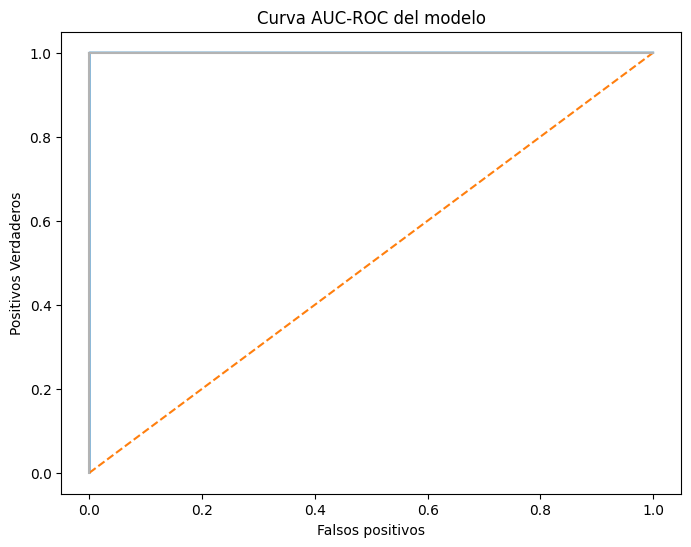

In [ ]:
plt.subplots(1, figsize=(8,6))
plt.title('Curva AUC-ROC del modelo')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Positivos Verdaderos')
plt.xlabel('Falsos positivos')
plt.show()

Dado el accuracy de 100% que alcanzamos con el modelo de regresión logística como se ha parametrizado, la curva AUC ROC nos muestra un

###**Gráfico de valores predichos y efectivos**

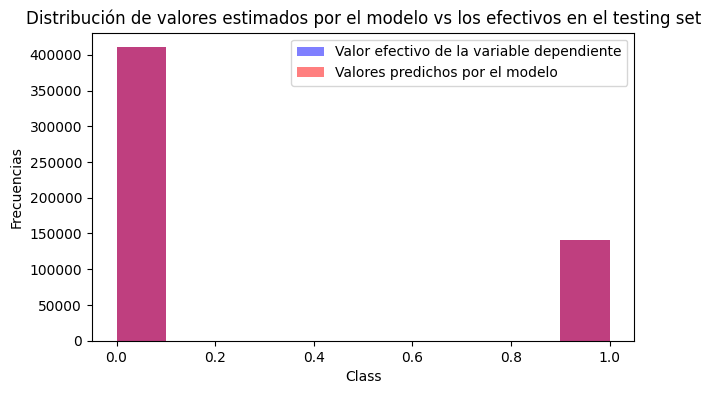

In [ ]:
#Graficamos los valores predichos por el modelo y los valores efectivos de la variable dependiente en el testing set.

plt.figure(figsize=(7, 4))
plt.hist(y_test, alpha=0.5, color='blue', label='Valor efectivo de la variable dependiente')
plt.hist(y_pred,  alpha=0.5, color='red', label='Valores predichos por el modelo')
plt.xlabel('Class')
plt.ylabel('Frecuencias')
plt.title('Distribución de valores estimados por el modelo vs los efectivos en el testing set')
plt.legend()
plt.show()

El gráfico confirma lo que se observaba en la matrix de confusión donde la mayoría, pero no la totalidad, de las observaciones del testing set son correctametne predichos por el modelo.